In [1]:
import sys, os
sys.path.append(os.path.realpath("../../../"))

In [1]:
%pip install treasury-ml-utils --extra-index-url https://arti.tw.ee/artifactory/api/pypi/pypi-internal/simple

Looking in indexes: https://pypi.org/simple, https://arti.tw.ee/artifactory/api/pypi/pypi-internal/simple
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached slack_sdk-3.37.0-py2.py3-none-any.whl.metadata (15 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached charset_normalizer-3.4.4-cp311-cp311-macosx_10_9_universal2.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2025.10.5-py3-none-any.whl.metadata (2.5 kB)
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 13.4 MB/s  0:00:01 eta 0:00:01
Using cached

In [1]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://transferwise.okta-emea.com/app/snowflake/exk4istpb5gZUyV8u0i7/sso/saml?SAMLRequest=nZJNc9owEIb%2Fikc925LNR0ADZGgoCU3SUjA5cBP2QjTIkquVY%2Fj3lfnopIfk0JtHfnefd%2Ffdwe2hUMEbWJRGD0kcMRKAzkwu9W5IVuk07JEAndC5UEbDkBwBye1ogKJQJR9X7lUv4HcF6ALfSCNvfgxJZTU3AiVyLQpA7jK%2BHD8%2F8SRiXCCCdR5HLiU5Ss96da7klNZ1HdWtyNgdTRhjlPWpVzWSL%2BQdovycUVrjTGbUteTgZ%2FoAEVPWbhBe4QnzS%2BFXqc8r%2BIyyOYuQP6TpPJz%2FXKYkGF%2BnuzMaqwLsEuybzGC1eDobQO9gkSY37aQXQRVmoJ0VKowj1KbeKrGHzBRl5XzjyH%2FRLeRUmZ3065pNhqTcy%2Fz7lN23lpJtJnPRaUPryKrHWW%2FRXbOHsvvrXjKV9B5vjs%2FfVllGgpdruEkT7gyxgpluInX%2BiSXdkMVh0k9ZzDt9HvejTru9JsHERyq1cKfKq2%2FvVOMWbC0RIrN3IoQCxMmmKEv6dwIKh31bois3nd16dXzpVUzeUERDm%2BzI%2BXz4yYod%2FcdSBvR9g8sx%2FvD5zCZzo2R2DKbGFsJ9HF8cxacXmYfbk5RDIaQa57kFRB%2BjUqa%2BsyCcv3

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from fitter import Fitter, get_common_distributions


#hourly_data = pd.ExcelFile('data_hourly.xlsx')
#sheet_names =hourly_data.sheet_names

In [4]:
df = snowflake_client.fetch(f"""
                            
SELECT *, 
       CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP) as NY_TIME,
       ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
WHERE CCY_PAIR IN ('EURUSD', 'GBPUSD', 'EURGBP', 'USDJPY', 'USDMXN','USDBRL', 'USDCOP', 'USDCNY', 'USDIDR', 'USDINR','USDMYR', 'USDPHP', 'USDKRW', 'USDTWD', 'USDTHB', 'USDVND')
  AND TENOR_CODE = 'SP'
  AND INSTRUMENT_TYPE = 'FXSpot'
  AND PROVIDER = 'BLOOMBERG'
  AND TIMESTAMP BETWEEN '2025-01-01 00:00:00' AND '2026-01-29 00:00:00'  
  

  AND DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) <> 6
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 5 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) >= 17)
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 7 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) < 17);
                            
""")

ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,EURUSD,GBPUSD,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND
timestamp,,,,,,,,,,,,,,,
2025-01-01 00:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 01:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 02:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 03:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05
2025-01-01 04:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.67000,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05


In [15]:
ccy_df['EURGBP'] = ccy_df['EURUSD']/ccy_df['GBPUSD']

In [17]:
# calculating log hourly returns

log_returns = np.log(ccy_df/ccy_df.shift(1))
log_returns.iloc[:15]

ccy_pair,EURUSD,GBPUSD,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND,EURGBP
timestamp,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000051,0.0
2025-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,-0.000627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [18]:
# mostly em pairs with many zeroes on log returns?

log_returns.describe()

ccy_pair,EURUSD,GBPUSD,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND,EURGBP
count,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000,6673.000000
mean,0.000022,0.000015,-0.000026,-0.000007,-0.000027,0.000006,0.000010,-0.000004,-0.000004,-0.000029,-0.000020,0.000002,-0.000014,-0.000007,0.000003,0.000007
std,0.001005,0.000935,0.001403,0.000302,0.001572,0.000629,0.000545,0.001203,0.001183,0.001296,0.000667,0.000629,0.000933,0.000802,0.000295,0.000655
min,-0.013295,-0.009467,-0.021679,-0.004666,-0.021722,-0.007888,-0.010130,-0.012569,-0.013869,-0.025468,-0.008194,-0.010995,-0.012170,-0.039961,-0.004435,-0.005730
25%,-0.000425,-0.000410,0.000000,-0.000036,0.000000,0.000000,0.000000,-0.000542,-0.000219,-0.000511,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000286
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000427,0.000444,0.000000,0.000034,0.000000,0.000000,0.000000,0.000577,0.000308,0.000440,0.000000,0.000000,0.000000,0.000000,0.000006,0.000286
max,0.012288,0.009605,0.022592,0.005520,0.025543,0.016262,0.007451,0.014794,0.016363,0.022321,0.008509,0.007983,0.014586,0.012071,0.006227,0.004629


In [24]:
x = log_returns['USDPHP'].dropna().to_numpy()

mu_hat, loc_hat, scale_hat = stats.t.fit(x, method="MLE")
print(mu_hat)
print(loc_hat)
print(scale_hat)

1.9883435173872193
2.4331353380156904e-23
5.737992408083655e-23


2026-01-29 11:17:04.367 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=16392855.477467)
2026-01-29 11:17:04.378 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=12895547.742552)
2026-01-29 11:17:04.381 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=16221804.062888)
2026-01-29 11:17:04.452 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=16584090.26628)
2026-01-29 11:17:04.464 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=16106928.664768)
2026-01-29 11:17:04.465 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=16238301.376903)
2026-01-29 11:17:04.473 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=14614905.257587)
2026-01-29 11:17:04.483 | INFO     | fitter

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm      1.288035e+07  7149.238866  7169.656341     inf      0.368813   
norm         1.289555e+07  6873.394352  6887.006002     inf      0.367991   
chi2         1.461491e+07  2257.751994  2278.169468     inf      0.455472   
exponpow     1.535923e+07  1948.031296  1968.448770     inf      0.432023   
rayleigh     1.610693e+07  -747.998057  -734.386408     inf      0.534786   

          ks_pvalue  
lognorm         0.0  
norm            0.0  
chi2            0.0  
exponpow        0.0  
rayleigh        0.0  
{'lognorm': {'s': 0.003509304576675103, 'loc': -0.17854788062779725, 'scale': 0.17854891881984603}}


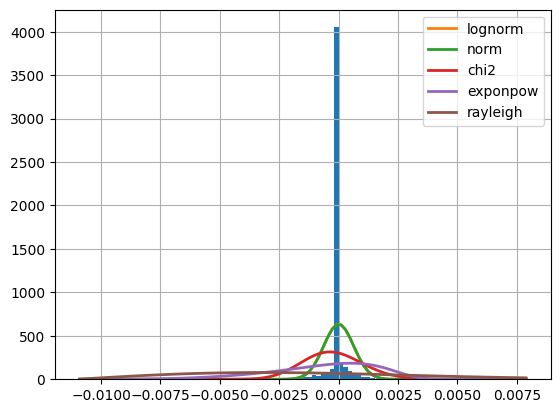

In [35]:
f = Fitter(x, distributions=get_common_distributions())
f.fit()
best_dist = f.get_best(method='sumsquare_error')
print(f.summary())
print(best_dist)

## generic pearson correlation

In [104]:
def correlations(df, target: list, feature_cols: list, method: str, window :int, min_frac: float):
    '''
    :param dataframe: dataframe of log returns
    :param target: list of target variables
    :param feature_cols: list of feature ccys that we want to run correlations for
    :param method: string of type of correlation method
    :param window: int of window size
    '''
    min_per = int(window*min_frac)
    correlations = {}


    for t in target:
        for f in feature_cols:
            key = f"{f} vs {t}"
            x = df[f].to_numpy()
            y = df[t].to_numpy()

            # creating the resulting array first
            res = np.full(len(df), np.nan, dtype=float)

            for i in range(window-1, len(df)):
                xs = x[i-window+1: i+1]
                ys = y[i-window+1: i+1] # 2 vectors to calculate correlation 
                ok = np.isfinite(xs) & np.isfinite(ys)
                xs, ys = xs[ok], ys[ok] # keep only valid observations

                if len(xs) < min_per:
                    continue

                if method == 'pearson':
                    r = scipy.stats.pearsonr(xs, ys)[0]
                elif method == 'spearman':
                    r = scipy.stats.spearmanr(xs, ys)[0]
                elif method == 'kendall':
                    r = scipy.stats.kendalltau(xs, ys)[0]
                else:
                    raise ValueError("method must be pearson, spearman or kendall")
                
                res[i] = r
        
            correlations[key] = pd.Series(res, index=df.index)
                    
    
    return pd.DataFrame(correlations)

In [97]:
def correlations(dataframe, target: list, feature_cols: list, method: str, window :int):
    '''
    :param dataframe: dataframe of log returns
    :param target: list of target variables
    :param feature_cols: list of feature ccys that we want to run correlations for
    :param method: string of type of correlation method
    :param window: int of window size
    '''
    correlations = {}

    for target_ccy in target:
        for feature_ccy in feature_cols:
            # calculating rolling correlation
            pair = f"{feature_ccy} VS {target_ccy}"
            if method == 'pearson':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'pearson')
            elif method == 'spearman':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'spearman')
            elif method == 'kendall':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'kendall')
                

    return pd.DataFrame(correlations)

In [134]:
em_pairs = ['USDCNY', 'USDKRW', 'USDMYR', 'USDINR', 'USDIDR', 'USDPHP', 'USDTWD','USDTHB', 'USDMXN', 'USDBRL', 'USDCOP']
majors = ['USDEUR', 'USDGBP', 'EURGBP']

pearson_df  = correlations(log_returns, majors, em_pairs, window=24*5, method="pearson", min_frac = 0.8)
spearman_df = correlations(log_returns, majors, em_pairs, window=24*5, method="spearman", min_frac = 0.8)
kendall_df  = correlations(log_returns, majors, em_pairs, window=24*5, method="kendall", min_frac = 0.8)

/var/folders/r6/lyd4620542j8pdy7dl_ccjtw0000gp/T/ipykernel_97166/3567466845.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)[0]
/var/folders/r6/lyd4620542j8pdy7dl_ccjtw0000gp/T/ipykernel_97166/3567466845.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.spearmanr(xs, ys)[0]


In [163]:
log_returns['USDKRW'].describe()

count    6.601000e+03
mean    -8.204267e-07
std      1.169851e-03
min     -1.386881e-02
25%     -2.167943e-04
50%      0.000000e+00
75%      3.068897e-04
max      1.636312e-02
Name: USDKRW, dtype: float64

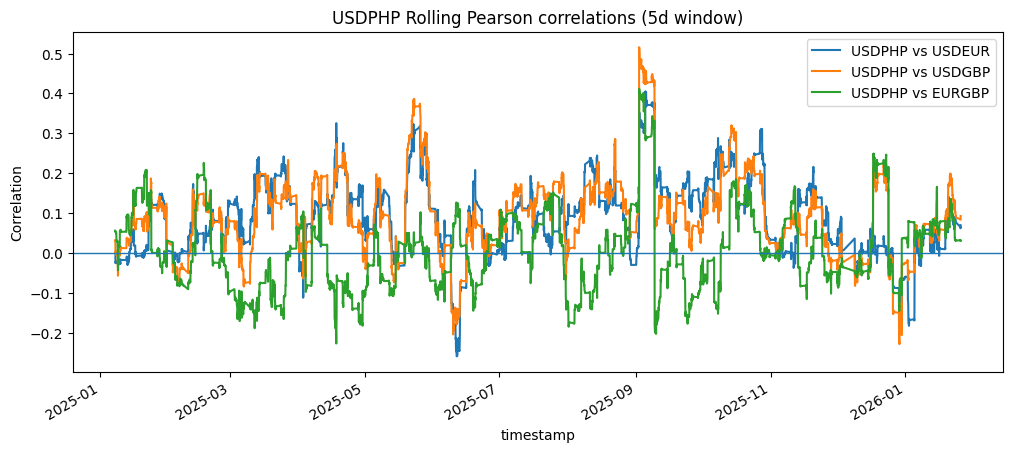

In [154]:
ccy = 'USDPHP'
cols = [f'{ccy} vs USDEUR', f'{ccy} vs USDGBP', f'{ccy} vs EURGBP']

ax = pearson_df[cols].dropna().plot(figsize=(12,5))
ax.axhline(0, linewidth=1)
ax.set_title(f"{ccy} Rolling Pearson correlations (5d window)")
ax.set_ylabel("Correlation")
plt.show()

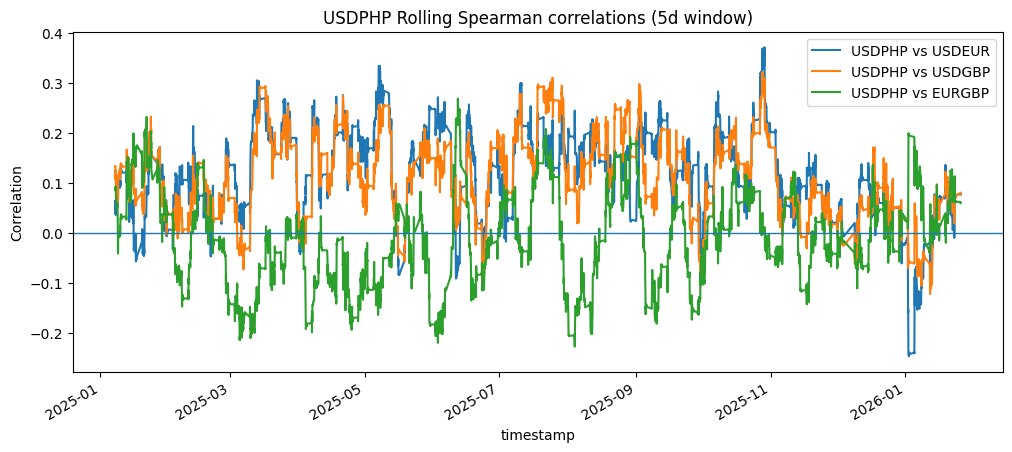

In [155]:
cols = ['USDMYR vs USDEUR', 'USDMYR vs USDGBP', 'USDMYR vs EURGBP']

cols = [f'{ccy} vs USDEUR', f'{ccy} vs USDGBP', f'{ccy} vs EURGBP']

ax = spearman_df[cols].dropna().plot(figsize=(12,5))
ax.axhline(0, linewidth=1)
ax.set_title(f"{ccy} Rolling Spearman correlations (5d window)")
ax.set_ylabel("Correlation")
plt.show()

In [156]:
spearman_df

,USDCNY vs USDEUR,USDKRW vs USDEUR,USDMYR vs USDEUR,USDINR vs USDEUR,USDIDR vs USDEUR,USDPHP vs USDEUR,USDTWD vs USDEUR,USDTHB vs USDEUR,USDMXN vs USDEUR,USDBRL vs USDEUR,...,USDKRW vs EURGBP,USDMYR vs EURGBP,USDINR vs EURGBP,USDIDR vs EURGBP,USDPHP vs EURGBP,USDTWD vs EURGBP,USDTHB vs EURGBP,USDMXN vs EURGBP,USDBRL vs EURGBP,USDCOP vs EURGBP
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23 20:00:00,0.230010,0.320916,-0.048040,0.097240,-0.039645,0.074299,-0.165345,0.124599,0.240081,0.091259,...,-0.087732,-0.165007,0.048923,0.152307,0.062906,-0.045541,-0.013335,0.107341,0.167352,-0.144386
2026-01-23 21:00:00,0.227202,0.319200,-0.047760,0.099029,-0.037082,0.075234,-0.165363,0.124221,0.233844,0.099883,...,-0.085932,-0.167437,0.052862,0.151994,0.062155,-0.046710,-0.015936,0.118460,0.184271,-0.148222
2026-01-25 22:00:00,0.221853,0.321641,-0.051971,0.125579,-0.035320,0.077331,-0.166459,0.121906,0.234240,0.095545,...,-0.085862,-0.166641,0.031472,0.150419,0.061194,-0.046203,-0.016345,0.079617,0.184366,-0.133060


In [127]:
z = 3.8

p = scipy.stats.norm.sf(z)   # 1 - Phi(z)
one_in_x = 1/p
one_in_x

13822.07376656924

In [129]:
df = 3
z = 5
p_one = scipy.stats.t.sf(z, df)
p_one_pct = 100*p_one
p_one_pct

0.7696219036651148

In [21]:
# for usdgbp

import plotly.express as px

# Filter just the data we want to plot
plot_data = daily_corr[usdgbp_cols].reset_index()

# Create interactive line chart
fig = px.line(plot_data, x='timestamp', y=usdgbp_cols,
              title='Daily Rolling Correlations vs USDGBP (Interactive - Zoom in!)',
              labels={'value': 'Correlation', 'variable': 'Currency Pair'})

# Customize: Add a range slider and highlight the 0 line
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True), # Adds a slider at the bottom
        type="date"
    ),
    yaxis=dict(range=[-1, 1]) # Fix y-axis to standard correlation limits
)

# Add a zero line to easily see when correlations flip negative
fig.add_hline(y=0, line_dash="dash", line_color="black")

fig.show()

In [22]:
# correlation ag gbp

# 1. Create a Month column
daily_corr['Month'] = daily_corr.index.month

# 2. Group by Month and take the average (Aggregating all years together)
# This creates a "Typical Year" profile for each currency
seasonality_matrix = daily_corr.groupby('Month')[usdgbp_cols].mean().T

# 3. Plot Heatmap
fig = px.imshow(seasonality_matrix,
                labels=dict(x="Month of Year", y="Currency Pair", color="Avg Correlation"),
                x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                color_continuous_scale='RdBu', # Red=High Corr, Blue=Inverse/Low
                zmin=-0.5, zmax=0.8, # Lock scale to see contrast
                title="Seasonality Heatmap: Do correlations cool off in Nov/Dec?")

fig.show()

In [23]:
# correlation ag eur

# 1. Create a Month column
daily_corr['Month'] = daily_corr.index.month

# 2. Group by Month and take the average (Aggregating all years together)
# This creates a "Typical Year" profile for each currency
seasonality_matrix = daily_corr.groupby('Month')[usdeur_cols].mean().T

# 3. Plot Heatmap
fig = px.imshow(seasonality_matrix,
                labels=dict(x="Month of Year", y="Currency Pair", color="Avg Correlation"),
                x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                color_continuous_scale='RdBu', # Red=High Corr, Blue=Inverse/Low
                zmin=-0.5, zmax=0.8, # Lock scale to see contrast
                title="Seasonality Heatmap: Do correlations cool off in Nov/Dec?")

fig.show()

<Figure size 1000x800 with 0 Axes>

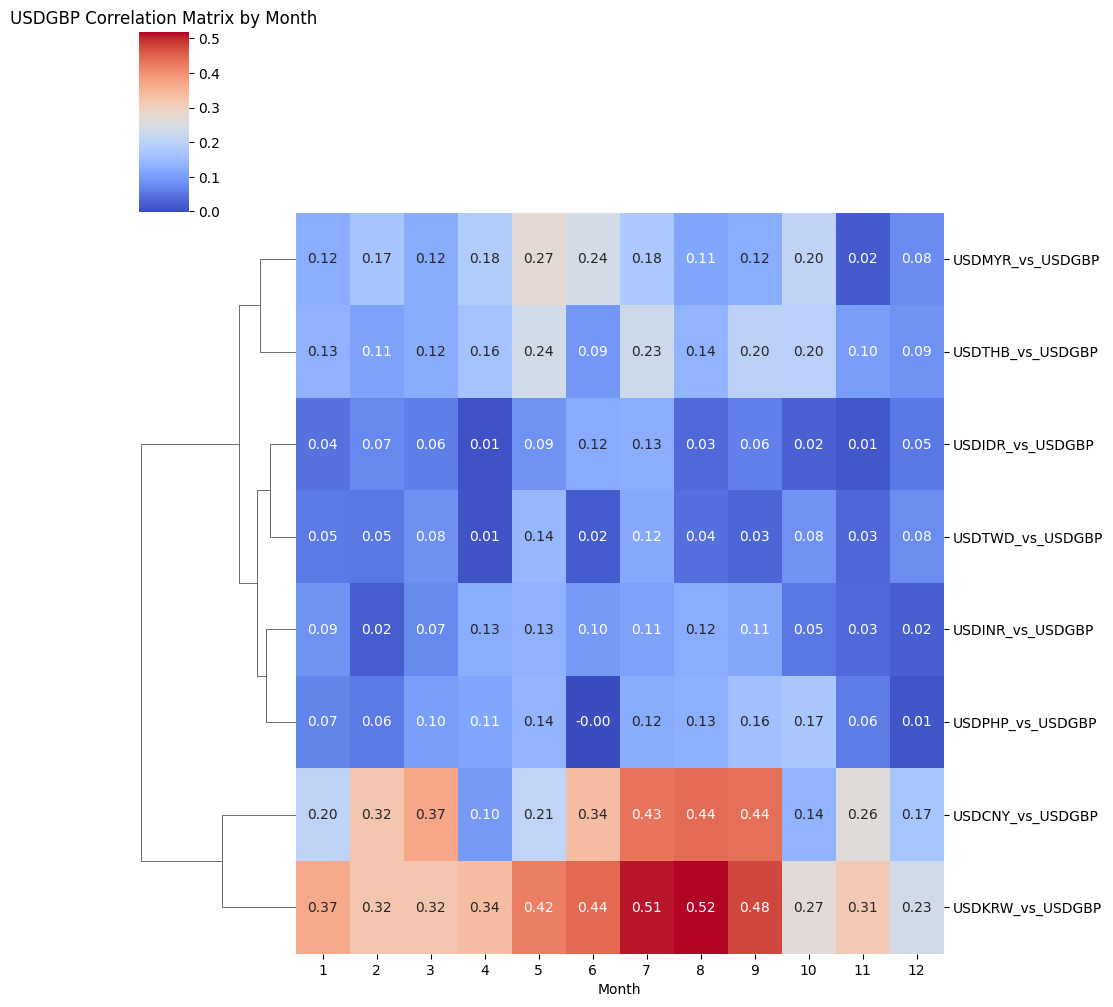

In [24]:
# plotting out correlation matrix

matrix = daily_corr.groupby('Month')[usdgbp_cols].mean().T

plt.figure(figsize=(10,8))
sns.clustermap(
    matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    col_cluster=False
)
plt.title('USDGBP Correlation Matrix by Month')
plt.show()

<Figure size 1000x800 with 0 Axes>

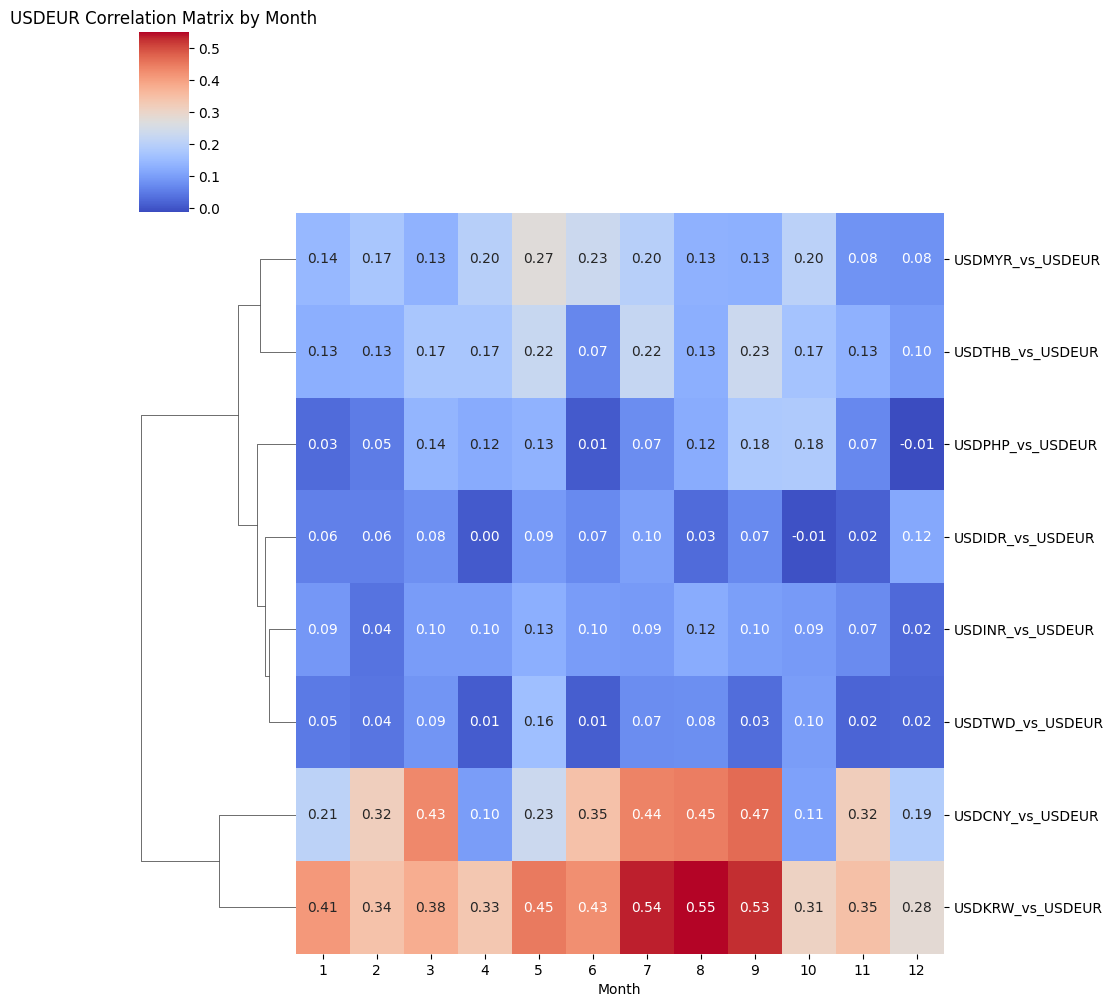

In [25]:
# plotting out correlation matrix

matrix = daily_corr.groupby('Month')[usdeur_cols].mean().T

plt.figure(figsize=(10,8))
sns.clustermap(
    matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    col_cluster=False
)
plt.title('USDEUR Correlation Matrix by Month')
plt.show()
